# **DEPENDENCIES**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import base64
import io
from PIL import Image
import tqdm
import time

# **ROBOFLOW UPLOAD**

In [4]:
ROBOFLOW_KEY = "BbhvgqhwoAejIuPghJ1M" # CONFIDENTIAL: Do not push images and annotations without editor access to the workspace

To upload images to Roboflow dataset

In [5]:
def upload_to_roboflow(path_to_image, split_type = 'train'):

    # split_type will upload image to train or valid dataset. Use train for now, we'll assign manually
    # Load Image with PIL
    image = Image.open(path_to_image).convert("RGB")

    # convert to JPEG Buffer
    buffered = io.BytesIO()
    image.save(buffered, quality = 90, format = "JPEG")

    # base 64 Encode
    img_str = base64.b64encode(buffered.getvalue())
    img_str = img_str.decode("ascii")

    # construct the URL
    upload_url = "".join([
        "https://api.roboflow.com/dataset/cloudphy-ap-final/upload",
        "?api_key=" + ROBOFLOW_KEY,
        f"&name={path_to_image}",
        f"&split={split_type}"
    ])

    # post to the API
    r = requests.post(upload_url, data = img_str, headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    })

    # output result
    print(r.json())

The annotation upload is not working for .txt YOLOv5 frmat

In [6]:
def annota_to_roboflow(path_to_annot):
  annotation_filename = path_to_annot

  # Read Annotation as String
  annotation_str = open(annotation_filename, "r").read()

  # Construct the URL
  upload_url = "".join([
      "https://api.roboflow.com/dataset/cloudphy-ap-final/upload",
      "?api_key=" + ROBOFLOW_KEY,
      "&name=", annotation_filename
  ])

  # POST to the API
  r = requests.post(upload_url, data=annotation_str, headers={
      "Content-Type": "text/plain"
  })

  # Output result
  print(r.json())

Use the following function call to push images to annotation workspace, name it in the format-- YourName_AnnotationScheme, function takes path of image as input, run it in loop for multiple images.

In [ ]:
# csv = pd.read_csv('/content/drive/MyDrive/Datasets/Classification Dataset/BPL-Ultima-PrimeD-A.csv')
# names = csv['image_name']
# pn = '/content/drive/MyDrive/Datasets/Classification Dataset/BPL-Ultima-PrimeD-A'
# for i in tqdm.tqdm(names):
#   upload_to_roboflow(pn + f'/{i}', split_type = 'train')

In [15]:
# upload_to_roboflow('/content/drive/MyDrive/Datasets/ClassificationShared2/images/aveksha_micu_mon-121_2021_11_23_13_30_2.jpeg')
# annota_to_roboflow('/content/drive/MyDrive/Datasets/ClassificationShared2/labels/aveksha_micu_mon-121_2021_11_23_14_0_3.txt')

{'success': True, 'id': 'TR5tA0UAKBh5BMixPVVp'}


# **YOLOS**

Following is a YOLOS implementation for detecting icu monitor loci. YOLOS is derived from ViT, which is a transformer based vision model. Due to is inherent transformer based architecture, we propose that YOLOS is able to capture long distance feature dependencies in an image, just like in languages the words in a sentence can have long range dependencies regardless of position. This is done with our observations in mind that the monitors present in the dataset are only a small subset of the various available format. In regular object detection task the entire object is inside a bounding box and has no dependency on the image outside it. 

This problem statement has a slightly different flavour. The object i.e., the vitals are numbers inside bounding boxes but their appeareance can be drastically different (almost 200 possible numeric values for various parameters combined 0-200), therefore the object does not have a unique identity as such, rather it's identity will be determined by it's locality. The locality will be having features like vital tags (HR, RCG, SPO2 etc.), graphs, special symbols ('/' in NIBP) which also contribute to the class prediction probabilty of YOLO. During bbox predictions, it is these features that decide which kind of vital is inside the box, rather than the number itself. With regular YOLO, 5 preds are done for each image patch, if these features are nearby then they are highly likely to get captured, but if they are blurred or otherwise occluded then long range feature dependency can be useful, say for example proximity to HR-wave can mean that the number detected is HR, even though HR tag is blurred. Since, YOLOS generates image patch tokens, these long distance features are also captures during training, and hypothetically help during inference on even drastically different monitor types (not used in training)

STRESSING - This is not a regular object detection task, rather this is a detecting object - based on it's locality task. The solution we propose is NOT YOLOS per say, rather what we say is -- use a model that can capture long range feature dependencies.

STRESSING - YOLOS is still only vanilla, there is lot of room for development asn optimization.

In [7]:
!pip install -q transformers==4.20.0
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 7.9 MB/s eta 0:00

Using my wandb account to observe the training process, Other team members can make similar accounts to do the same.

In [4]:
# To log our training metrics we need to log in to Weights & Biases with our API key, you can sign up for free here: https://wandb.ai/site
import wandb
wandb.login()
# API key (Aditya Prakash): f5d9fbabe83bfb6f1f1f70bcc178a865cbbd5072

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
# Dataset Download
# TO GET DATASET DOWNLOAD VISIT https://app.roboflow.com/?model=YOLOS&ref=YOLOS
from roboflow import Roboflow
rf = Roboflow(api_key=ROBOFLOW_KEY)
# This project has all images of classification dataset provided by CloudPhy
project = rf.workspace("aditya-prakash-3tcmk").project("cloudphy-ap-final")
# The downloaded directory has all information on the augmentation and preprocessing regime in the accompanying txt file
dataset = project.version(1).download("coco")

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to cloudphy-ap-final-1 in coco:: 100%|██████████| 2475/2475 [00:03<00:00, 629.04it/s]


In [9]:
# where is the dataset ?
dataset.location

'/content/cloudphy-ap-final-1'

In [11]:
# Register dataset as torchvision CocoDetection
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-tiny", size=720, max_size=864)

train_dataset = CocoDetection(img_folder=(dataset.location + '/train'), feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=(dataset.location + '/valid'), feature_extractor=feature_extractor, train=False)
test_dataset = CocoDetection(img_folder=(dataset.location + '/test'), feature_extractor=feature_extractor, train=False)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 2287
Number of validation examples: 100
Number of test examples: 80


Image n°1434


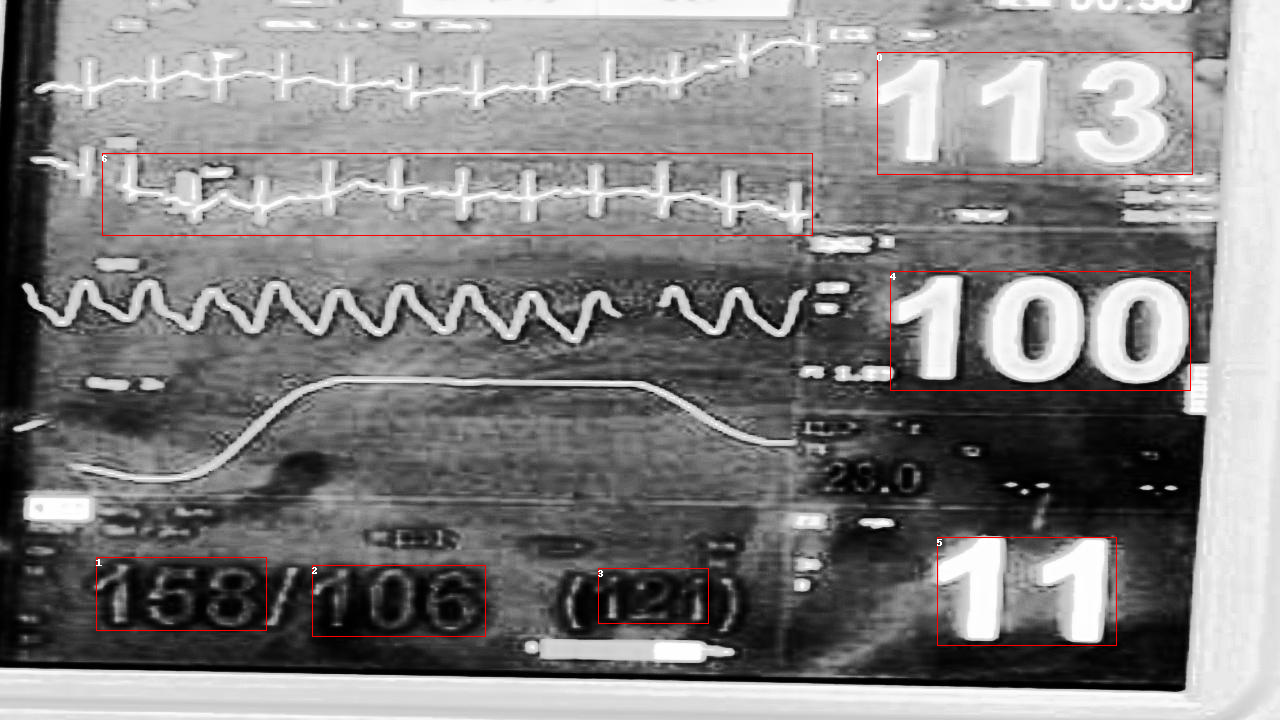

In [12]:
# Vizualize that our data has loaded correctly - You can hit this cell as many times as you want to vizualize how your training set has loaded
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + '/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [13]:
# Setup dataloader for training loop

from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

## **YOLOS Training Config**

In [14]:
# For training configuration, start from the pretrained YOLOS-tiny model from 
# Hugging Face transformers

import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch

# we wrap our model around pytorch lightning for training
class YoloS(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny", 
                                                                  num_labels=len(id2label),
                                                                  ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.weight_decay = weight_decay
         self.save_hyperparameters()  # adding this will save the hyperparameters to W&B too

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("train/loss", loss)  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("train/" + k, v.item())  # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss) # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace
        for k,v in loss_dict.items():
          self.log("validation/" + k, v.item()) # logging metrics with a forward slash will ensure the train and validation metrics as split into 2 separate sections in the W&B workspace

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [17]:
# initialize the model
model = YoloS(lr=2.5e-5, weight_decay=1e-4)

Downloading:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.8M [00:00<?, ?B/s]

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([9, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Train**

In [18]:
# import wandb
# #you can name your wandb project however you like, 
# #in this project you will be able to compare training runs
# wandb.init(project="my-test-project")
# from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning import Trainer

# wandb_logger = WandbLogger()

In [20]:
!pip install --upgrade wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Name your wandb project and upload the final checkpoint to wandb, according to ModelCheckpoint
# Click on the output wandb run name below to see your metrics updating live in wandb
wandb_logger = WandbLogger(project='cloudphy-roboflow-yolos', log_model=True)

# Keep track of the checkpoint with the lowest validation loss
checkpoint_callback = ModelCheckpoint(monitor="validation/loss", mode="min")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **TRAIN** **CELL**

In [22]:
from pytorch_lightning import Trainer

# more epochs leads to a tighter fit of the model to your data.
# we set epochs=50 here for an example of quick training
# checkpoint_callback to log model to W&B at end of training and changed log_every_n_steps=5 to generate better charts
trainer = Trainer(gpus = 1, 
                  max_epochs = 50, 
                  gradient_clip_val = 0.1, 
                  accumulate_grad_batches = 8, 
                  log_every_n_steps = 5, 
                  logger = wandb_logger, 
                  callbacks = [checkpoint_callback])

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
Checkpoint directory ./cloudphy-roboflow-yolos/version_None/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 6.5 M 
--------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.891    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

SAVE AND LOAD MODEL

In [ ]:
# Save model
save_path = 'save_path/model_name.pt'
torch.save(model.state_dict(), save_path)

In [17]:
# Load model using new intance and restoring parameters
load_path = '/content/drive/MyDrive/Datasets/YOLOS1.pt'
model = YoloS(lr=2.5e-5, weight_decay=1e-4)
# For using GPU, remove map_location parameter
model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([9, 192]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
This error is indicating that the type of the input and the weight tensors are different, and they should 
be the same. In your code, you are using a CUDA tensor for the input (pixel_values.to(device)), but the
weight tensors are still on the CPU (torch.FloatTensor).
To resolve this, you can move the weight tensors to the GPU as well, using model.to(device).

In [ ]:
# model.to(device)

# **EVALUATION**

In [23]:
# clean up torch tensors before eval so your gpu memory doesn't crash!
torch.cuda.empty_cache()

In [18]:
# we borrow the eval scripts from the DETR repo as they provide similar functionality to what we need to calculate mAP
!git clone https://github.com/facebookresearch/detr.git
%cd /content/detr

Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 12.87 MiB | 26.00 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/detr


In [19]:
from datasets import get_coco_api_from_dataset
base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute

In [20]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()
# the evaluation here prints out mean average precision details
# learn more - https://blog.roboflow.com/mean-average-precision/

Running evaluation...


  0%|          | 0/100 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.937
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.447
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

In [27]:
# MORGAN: We can add final summary metrics to our wandb run using wandb.summary
wandb.summary['AP_IOU-0.5_all'] = 0.052

# **Visualisation**

In [21]:
# We can use the image_id in target to know which image it is

pixel_values, target = val_dataset[24]
pixel_values = pixel_values.unsqueeze(0).to(device)
t1=time.time()
outputs = model(pixel_values=pixel_values)
t2=time.time()
k = t2 - t1 # time taken to run model, not including post processing time

In [128]:
import torch
import matplotlib.pyplot as plt

# lower confidence yields more, but less accurate predictions
CONFIDENCE=0.3

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=CONFIDENCE):
  # keep only predictions with confidence >= threshold
  t1 = time.time()
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
  t2 = time.time()
  print(f'Total inference time = {k + t2 -t1} s')
  print()

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [47]:
# MORGAN
def log_image_bboxes_to_wandb(image, outputs, image_name='my_image', threshold=CONFIDENCE):
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  box_data = []
  for p,bbox in zip(probas, bboxes_scaled):
    position = dict(
                minX=int(bbox[0]),
                minY=int(bbox[1]),
                maxX=int(bbox[2]),
                maxY=int(bbox[3])
                )
    cl = int(p.argmax().cpu().detach().item())
    scores = {"loss": p[cl].cpu().detach().item()}

    box_data.append({
                'position': position,
                'class_id': cl,
                'scores' : scores,
                'domain': 'pixel'
            })

  wandb_bbox_dict = {
              'box_data': box_data,
              'class_labels': id2label
          }
  wandb_boxes = {}
  wandb_boxes['predictions'] = wandb_bbox_dict

  # Log the image with bounding boxes to wandb
  img = wandb.Image(image, boxes=wandb_boxes)
  wandb.log({image_name:img})
  print('Image with bounding boxes logged to your wandb run!')

Total inference time = 0.021282672882080078 s



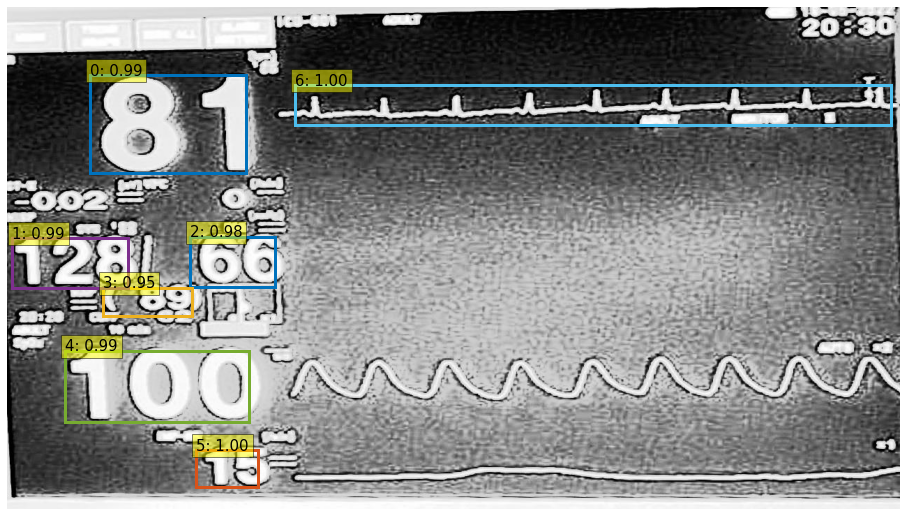

In [84]:
image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(dataset.location + '/valid', image['file_name']))

visualize_predictions(image, outputs)

In [ ]:
# MORGAN: We can also log our predicted images with bounding boxes to our wandb run
log_image_bboxes_to_wandb(image, outputs, image_name='my_prediction_image')  # MORGAN 
wandb.finish()

# **EXTERNAL INFERENCE ENTRYPOINT**

In [116]:
from PIL import ImageOps

class CocoDet_extinf(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        self.img_folder = img_folder
        self.feature_extractor = feature_extractor
        self.ids = [f.replace('.jpeg', '') for f in os.listdir(img_folder) if f.endswith('.jpeg')]

    def __getitem__(self, idx):
        # read in PIL image
        img_path = os.path.join(self.img_folder, self.ids[idx]+'.jpeg')
        img = Image.open(img_path).convert("RGB")

        # equalize the histogram of the image
        img_eq = ImageOps.equalize(img)

        # convert the image to grayscale
        img_eq = img_eq.convert('L')
        # feature extractor needs 3 channel image, grayscale images from roboflow were 3 channel too
        img_eq = torch.from_numpy(np.array(img_eq)).unsqueeze(0).repeat(3, 1, 1)

        # preprocess image (resizing + normalization)
        encoding = self.feature_extractor(images=img_eq, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension

        return pixel_values

In [124]:
inf_dataset_path = '/content/drive/MyDrive/ClassificationShared2/images'
inf_dataset = CocoDet_extinf(img_folder=inf_dataset_path, feature_extractor=feature_extractor, train=False)

In [132]:
# We can use the image_id in target to know which image it is

pixel_values = inf_dataset[607]
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)
t1=time.time()
outputs = model(pixel_values=pixel_values)
t2=time.time()
# DONT CHANGE VARIABLE NAME 
k = t2 - t1 # time taken to run model, not including post processing time

torch.Size([1, 3, 486, 864])


Total inference time = 2.6918506622314453 s



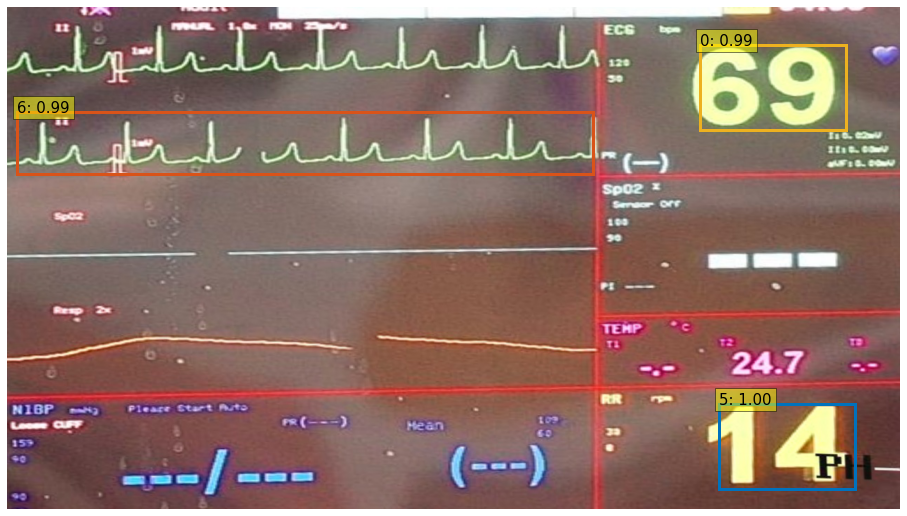

In [133]:
image = inf_dataset.ids[607]
image = Image.open(os.path.join(inf_dataset.img_folder, f"{image}.jpeg"))
visualize_predictions(image, outputs)